In [1]:
import os

try:
    has_changed_dir
except:
    has_changed_dir = False

try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False

if IN_COLAB:
    %pip install datasets
    %pip install translate-toolkit
    %pip install bitsandbytes

    !git clone https://github.com/MarkusSibbesen/mechinterp_research_project.git

    from google.colab import drive
    drive.mount('/content/drive/')

    if not has_changed_dir:
        os.chdir('mechinterp_research_project')
        has_changed_dir = True
else:
    if not has_changed_dir:
        os.chdir('.')
        has_changed_dir = True

Running as a Colab notebook
fatal: destination path 'mechinterp_research_project' already exists and is not an empty directory.
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModelForCausalLM
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np
import einops


from src.sparse_autoencoders import SAE_topk

# Automatically select GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
load_from_drive = True

model_url = "EleutherAI/pythia-1.4b"
model_name = model_url.split('/')[-1]
hookpoint_name = 'gpt_neox.layers.$.mlp.act'
layer = 16

# model = AutoModelForCausalLM.from_pretrained(model_url).to(device)
# tokenizer = AutoTokenizer.from_pretrained(model_url)

# num_hookpoints = model.config.num_hidden_layers
# input_size = model.config.intermediate_size

# del model

hookpoint = hookpoint_name.replace('$', str(layer))
num_hookpoints = 24
input_size = 8192

expansion_factor = 8
meta_data = {
    'input_size': input_size,
    'hidden_size': input_size * expansion_factor,
    'k': 32,
    "pre_encoder_bias": True,
    "same_W": False
}

k = meta_data['k']

sae = SAE_topk(meta_data=meta_data).to(device)

if load_from_drive:
    sae.load_state_dict(torch.load(f'../drive/MyDrive/models/{hookpoint}.pt', weights_only=True, map_location=device))
else:
    sae.load_state_dict(torch.load(f'models/sparse_autoencoders/pythia-14m/topk{k}/{hookpoint}.pt', weights_only=True, map_location=torch.device('cpu')))

In [4]:
neuron_to_ablate = 26335


def ablate_model(model, sae, hookpoint, neuron_to_ablate):

    def hook(module, _, outputs):


        h = sae.get_activations(outputs)

        zeros = torch.zeros(h.indices.shape[0], h.indices.shape[1], sae.meta_data['hidden_size']).to(device)

        if neuron_to_ablate != None:
            for batch_idx in range(h.indices.shape[0]):
                for sent_idx in range(h.indices.shape[1]):
                    indices = h.indices[batch_idx, sent_idx]
                    values = h.values[batch_idx, sent_idx]
                    zeros[batch_idx][sent_idx][indices] = values

                    zeros[batch_idx][sent_idx][neuron_to_ablate] = -8

        x_hat = einops.einsum(zeros, sae.W, 'batch token latent, latent out -> batch token out')
        x_hat += sae.pre_encode_b

        return x_hat

    attached_hook = model.get_submodule(hookpoint).register_forward_hook(hook)

    return attached_hook

In [5]:
# with ablate_model(model, sae, hookpoint, neuron_to_ablate):
#     tokenized = tokenizer('Dette er en', return_tensors='pt')
#     ids = model.generate(tokenized.input_ids, max_length=100)

#     print(tokenizer.decode(ids[0]))

In [6]:


dataset_size = 2000
batch_size = 16

print(f"Using device: {device}")

class TextDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.inputs.items()}
        label = self.labels[idx]
        return item, label

def get_last_hidden_state(model, dataloader):
    """
    Extract the last hidden layer activations from GPT-2 using batches.
    """
    activation_data = []

    model.eval()  # Ensure the model is in evaluation mode
    c = 0
    with torch.no_grad():
        for batch in dataloader:
            print(c)
            inputs, _ = batch
            input_ids = inputs["input_ids"].to(device)
            attention_mask = inputs["attention_mask"].to(device)

            # Forward pass through the model
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)

            # *** HERE WE INSERT THE ABLATED MODEL'S HIDDEN STATE***

            last_hidden_states = outputs.hidden_states[-1]  # Shape: (batch_size, sequence_length, hidden_size)

            # Pool over sequence length (average pooling)
            pooled_activations = last_hidden_states.mean(dim=1).cpu().numpy()  # Shape: (batch_size, hidden_size)
            activation_data.extend(pooled_activations)
            c+=1

    return activation_data

def training_pipeline(model, dataloader, labels):
    print("Getting last hidden state activations...")
    activation_data = get_last_hidden_state(model, dataloader)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(activation_data, labels, test_size=0.2, random_state=42)

    print("Training downstream model...")
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class; 'binary' for binary classification
    return f1

def angry_tweet(tokenizer):
    print("Loading angry tweets...")

    dataset = load_dataset("DDSC/angry-tweets")
    texts = dataset['train']['text'][0:dataset_size]
    labels = dataset['train']['label'][0:dataset_size]
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

    label_mapping = {'positiv': 0, "neutral": 1, "negativ": 2}
    labels = [label_mapping[label] for label in labels]
    return inputs, labels

def scala(tokenizer):
    print("Loading Scala dataset...")
    dataset = load_dataset("alexandrainst/scala", "da")

    texts = dataset['full_train']['text'][0:dataset_size]
    labels = dataset['full_train']['label'][0:dataset_size]
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

    label_mapping = {'incorrect': 0, "correct": 1}
    labels = [label_mapping[label] for label in labels]

    return inputs, labels

def tweet_sentiment_extraction(tokenizer):
    print("Loading tweet_sentiment_extraction...")

    dataset = load_dataset("SetFit/tweet_sentiment_extraction")
    texts = dataset['train']['text'][0:dataset_size]
    labels = dataset['train']['label'][0:dataset_size]
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)

    return inputs, labels

def import_model(model_name, ablate=False):
    # Load the tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token  # Add padding token compatibility
    model = AutoModelForCausalLM.from_pretrained(model_name).to(device)  # Move model to the selected device


    hook = ablate_model(model, sae, hookpoint, neuron_to_ablate)

    return model, tokenizer

def run():
    model_name = "openai-community/gpt2"
    model_name = "EleutherAI/pythia-1.4b"
    model, tokenizer = import_model(model_name)

    # Process Angry Tweets dataset
    inputs, labels = angry_tweet(tokenizer)
    dataset = TextDataset(inputs, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    f1_angry_tweet = training_pipeline(model, dataloader, labels)
    print("f1_angry_tweet",f1_angry_tweet)

    # Process Scala dataset
    inputs, labels = scala(tokenizer)
    dataset = TextDataset(inputs, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    f1_scala = training_pipeline(model, dataloader, labels)
    print("f1_scala",f1_scala)

    # Process tweet_sentiment_extraction dataset
    inputs, labels = tweet_sentiment_extraction(tokenizer)
    dataset = TextDataset(inputs, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size)
    f1_english_tweet = training_pipeline(model, dataloader, labels)
    print("f1_english_tweet", f1_english_tweet)

    return f1_angry_tweet, f1_scala, f1_english_tweet

# Run the pipeline
f1_angry, f1_scala, f1_english_tweet = run()

print(f"F1 Score on Angry Tweets Dataset: {f1_angry}")
print(f"F1 Score on Scala Dataset: {f1_scala}")
print(f"F1 Score on english tweets Dataset: {f1_english_tweet}")

Using device: cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading angry tweets...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Getting last hidden state activations...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
Training downstream model...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


f1_angry_tweet 0.6130533685032463
Loading Scala dataset...
Getting last hidden state activations...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
Training downstream model...
f1_scala 0.47128283693619893
Loading tweet_sentiment_extraction...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Repo card metadata block was not found. Setting CardData to empty.


Getting last hidden state activations...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
Training downstream model...
f1_english_tweet 0.5963567529117352
F1 Score on Angry Tweets Dataset: 0.6130533685032463
F1 Score on Scala Dataset: 0.47128283693619893
F1 Score on english tweets Dataset: 0.5963567529117352


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [7]:
model_name = "EleutherAI/pythia-1.4b"
model, tokenizer = import_model(model_name)


In [ ]:
inputs = tokenizer("Hello, I am", return_tensors = "pt")
tokens = model.generate(**inputs)
tokenizer.decode(tokens[0])

In [ ]:
model

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 2048)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-23): 24 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXSdpaAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=2048, out_features=6144, bias=True)
          (dense): Linear(in_features=2048, out_features=2048, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=2048, out_features=8192, bias=True)
          (dense_4h_to_h): Linear(in_features=8192, out_features=2048, bias=True

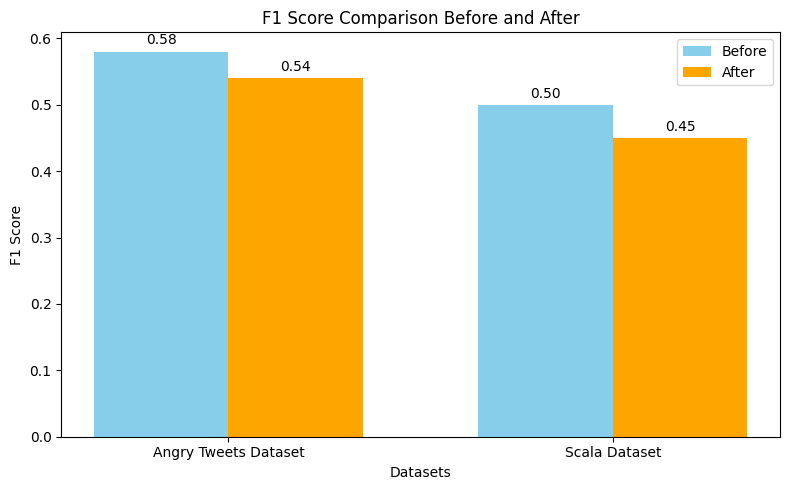

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Angry Tweets Dataset', 'Scala Dataset']
before_scores = [0.58, 0.50]
after_scores = [0.54, 0.45]

# Bar width and positions
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Plot
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, before_scores, width, label='Before', color='skyblue')
bars2 = ax.bar(x + width/2, after_scores, width, label='After', color='orange')

# Labels, title, and legend
ax.set_xlabel('Datasets')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Score Comparison Before and After')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Add values on top of the bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset text position
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


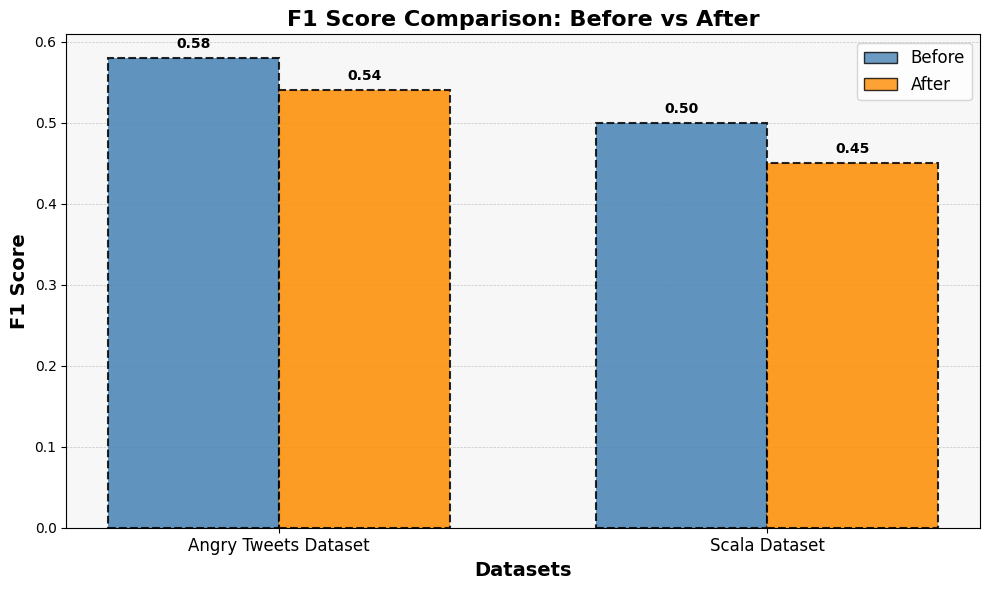

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Angry Tweets Dataset', 'Scala Dataset']
before_scores = [0.58, 0.50]
after_scores = [0.54, 0.45]

# Bar width and positions
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(
    x - width / 2, before_scores, width, label='Before',
    color='steelblue', edgecolor='black', linewidth=1, alpha=0.8
)
bars2 = ax.bar(
    x + width / 2, after_scores, width, label='After',
    color='darkorange', edgecolor='black', linewidth=1, alpha=0.8
)

# Add value annotations
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(
            f'{height:.2f}',
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 5),  # Offset text position
            textcoords="offset points",
            ha='center', va='bottom',
            fontsize=10, fontweight='bold', color='black'
        )

# Styling
ax.set_xlabel('Datasets', fontsize=14, fontweight='bold')
ax.set_ylabel('F1 Score', fontsize=14, fontweight='bold')
ax.set_title('F1 Score Comparison: Before vs After', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)
ax.legend(fontsize=12, loc='upper right')

# Gridlines and Background
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)  # Gridlines behind bars
ax.set_facecolor('#f7f7f7')  # Subtle background color

# Rounded bar edges
for bar in bars1 + bars2:
    bar.set_linewidth(1.5)
    bar.set_edgecolor('black')
    bar.set_alpha(0.85)
    bar.set_linestyle('--')

# Tight layout and display
plt.tight_layout()
plt.show()
